In [1]:
import numpy as np
import os, re
from Data import dataExp
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, TextDataset, DataCollatorForLanguageModeling
from tensor2tensor.data_generators import text_encoder

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
author = "Caesar"

In [3]:
CI = dataExp.CorpusInterface(corpus_name="text_corpus.pickle", shouldTokenize = False)
text = CI.get_text_for_author(author=author,shouldShuffle=True)

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 34398 characters of text
abelard had 1 pieces of work with a total of 85089 characters of text
acticussincerius had 3 pieces of work with a total of 23788 characters of text
addison had 1 pieces of work with a total of 1764 characters of text
adso had 1 pieces of work with a total of 13551 characters of text
aelredus had 1 pieces of work with a total of 118173 characters of text
agnes had 1 pieces of work with a total of 74784 characters of text
alanus had 1 pieces of work with a total of 195061 characters of text
albericodamarcellise had 1 pieces of work with a total of 172 characters of text
albertanus had 1 pieces of work with a total of 18033 characters of text
albertofaix had 1 pieces of work with a total of 85671 characters of text
alcuin had 1 pieces of work with a total of 2642 characters of text
aleandrogerolamo had 2 pieces of work with a total of 13499 characters of text
alfonsi had 1 pieces of wo

In [4]:
with open(f"{author}_data.txt", "w+") as f:
    f.write(text)
print(len(text))

1473628


In [4]:
path_to_latin_bert = "./LatinBERT/"
tokenizer = AutoTokenizer.from_pretrained(path_to_latin_bert)
model = AutoModelForMaskedLM.from_pretrained(path_to_latin_bert+"latin_bert/")
model.to(device)

Some weights of the model checkpoint at ./LatinBERT/latin_bert/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32900, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [45]:
# Tokenize the text data
# encoded_data = tokenizer(text, return_tensors='pt')

Token indices sequence length is longer than the specified maximum sequence length for this model (352139 > 512). Running this sequence through the model will result in indexing errors


In [6]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item[0]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item[1]) for item in batch])
    labels = torch.stack([torch.tensor(item[2]) for item in batch])

    # Move data to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [7]:
from torch.utils.data import DataLoader
#from multiprocessing import cpu_count
# Define the dataset and data collator for training the model
dataset = TextDataset(file_path=f"{author}_data.txt", tokenizer=tokenizer, block_size=256)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.35)

#num_workers = cpu_count()
#print(num_workers)

train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)


/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (352137 > 512). Running this sequence through the model will result in indexing errors


In [8]:
import pickle
def save_object(obj, filename):
    with open(filename, "wb") as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(train_dataloader, f"{author}_dataset.pickle")

In [9]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [10]:
torch.cuda.empty_cache()

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    epoch_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        # forward pass
        #print(batch["input_ids"].size())
        #batch["input_ids"].to(device)
        #batch['labels'].to(device)
        
        outputs = model(input_ids=batch['input_ids'].to(device),labels=batch['labels'].to(device))
        loss = outputs.loss
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        epoch_train_loss+=train_loss
        train_loss_step.append(loss.item())
        
        # log training progress
        if (step + 1) % log_interval == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Step [{step + 1}/{len(train_dataloader)}]: Train loss = {train_loss / log_interval}")
            train_loss = 0
            
    train_loss_epoch.append(epoch_train_loss / len(train_dataloader))

Epoch [1/200] Step [20/174]: Train loss = 3.2789806723594666
Epoch [1/200] Step [40/174]: Train loss = 2.9643692851066588
Epoch [1/200] Step [60/174]: Train loss = 2.926290047168732
Epoch [1/200] Step [80/174]: Train loss = 2.961133122444153
Epoch [1/200] Step [100/174]: Train loss = 2.9426745772361755
Epoch [1/200] Step [120/174]: Train loss = 2.905635643005371
Epoch [1/200] Step [140/174]: Train loss = 2.774307036399841
Epoch [1/200] Step [160/174]: Train loss = 2.8412150859832765
Epoch [2/200] Step [20/174]: Train loss = 2.785649263858795
Epoch [2/200] Step [40/174]: Train loss = 2.7073137521743775
Epoch [2/200] Step [60/174]: Train loss = 2.7949732899665833
Epoch [2/200] Step [80/174]: Train loss = 2.8498963594436644
Epoch [2/200] Step [100/174]: Train loss = 2.8285470962524415
Epoch [2/200] Step [120/174]: Train loss = 2.8460800290107726
Epoch [2/200] Step [140/174]: Train loss = 2.701103377342224
Epoch [2/200] Step [160/174]: Train loss = 2.786465620994568
Epoch [3/200] Step [20/

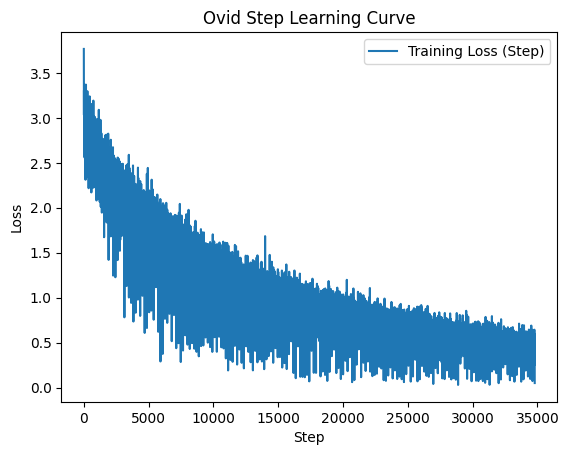

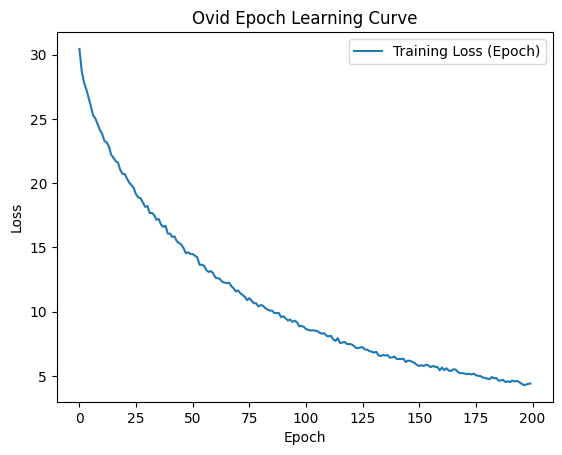

In [12]:
# plot learning curve
import matplotlib.pyplot as plt

plt.plot(train_loss_step, label='Training Loss (Step)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title(f"{author} Step Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Step_Learning_Curve.png")
plt.show()
plt.plot(train_loss_epoch, label='Training Loss (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"{author} Epoch Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Epoch_Learning_Curve.png")
plt.show()

In [11]:
model.save_pretrained(f"./{author}-finetuned/")

In [65]:
bee_input_text = "Qualis apes aestate nova per florea rura exercet sub sole labor, cum gentis adultos educunt fetus,".lower()
input_text = "At pater infelix, nec iam pater, Icare, dixit, Icare, dixit ubi es? qua te regione requiram? Icare dicebat:".lower()
input_text_2 = "Rapidi vicinia solis mollit odoratas, pennarum vincula, ceras. Tabuerant cerae: nudos quatit ille lacertos, remigioque carens non ullas percipit auras, oraque caerulea patrium clamantia nomen excipiuntur aqua: quae nomen traxit ab illo."
input_ids = tokenizer.encode(input_text, return_tensors='pt')
outputs = model.generate(input_ids=input_ids.to(device), max_length=50, do_sample=True)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(predicted_text)

at pater infelix, nec iam pater, icare, dixit, icare, dixit ubi es? qua te regione requiram? icare dicebat :'fluctibus ille nomen.'omnibus est, ait, tellus : pater est locus illi. quid facerat? quem fugiens inimicus amabat, proximus huic terrae frater erat. fluctibus actum erat. omnibus hoc visum est : venit enim, mox " nominat " unus, " et vidi? " an " dixi " quod lumen habebat? " " hoc


In [63]:
with open(f"Results/{author}_bert_gen.txt","w+") as f:
    f.write(predicted_text)

In [22]:
tokenizer.convert_ids_to_tokens(tokenizer.encode(input_text))

['[CLS]',
 'gallia_',
 'est_',
 'omnis_',
 'divisa_',
 'in_',
 'partes_',
 'tres_',
 ',_',
 'quarum_',
 'unam_',
 'incolu',
 'nt_',
 'bel',
 'gae_',
 ',_',
 'aliam_',
 'aqui',
 'tani_',
 ',_',
 'tertiam_',
 'qui_',
 'ipsorum_',
 'lingua_',
 'celt',
 'ae_',
 ',_',
 'nostra_',
 'galli_',
 'appellantur_',
 '._',
 '[SEP]']

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./LatinBERT/")
model = AutoModelForMaskedLM.from_pretrained("./Caesar-finetuned/")
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32900, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [10]:
prompt = "olim nomine rufo iuvenis ingeniosus erat,".lower()
input_ids = tokenizer.encode(prompt, return_tensors='pt')
outputs = model.generate(input_ids=input_ids.to(device), max_length=50, do_sample=True)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(type(model))
print(predicted_text)

<class 'transformers.models.bert.modeling_bert.BertForMaskedLM'>
olim nomine rufo iuvenis ingeniosus erat, sed numero hominum, quos illi attribuit, equos attribuit, arma, equos, equos attribuit. huic se atque suos attribuit ; huic marcum brutum praeficit. his copiis quintum um praeficit ; huic marcum
